Multiple_Myeloma_data_challenge
============================
Technical test for Data Scientist (DS) position in the Computational Biology team

Katarzyna Wreczycka 17.10.2022




Clinical context
-------------------
Multiple Myeloma (MM) is a type of bone marrow cancer. Treatment for MM involves
combinations of drugs over multiple cycles. There is huge heterogeneity in treatment
response with some individuals being non-responders and some patients remaining well for
some time before a relapse. A better characterization of patients who relapse early can
influence the treatment options and combinations.

In this test, we propose to develop a model for predicting the risk of dying or relapsing of
newly diagnosed multiple myeloma patients from baseline clinical and expression data.


Data
--------------------------
The data for this test are extracted from an old Synapse Dream Challenge
(https://www.synapse.org/#!Synapse:syn6187098/wiki/401884) .
It consists of clinical data, gene expression data and follow-up for newly diagnosed Multiple
Myeloma patients extracted from the MMRF CoMMpass IA9 study. In the data, newly
diagnosed MM patients are classified as High Risk (HR) when they relapse or die before 18
months.
To access the data, you first need to create an account and download the following files:
- Expression data:
MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv
(https://www.synapse.org/#!Synapse:syn10573789)
[notice that the first column gives Entrez IDs for genes]
- Clinical data and labels:
sc3_Training_ClinAnnotations.csv
(https://www.synapse.org/#!Synapse:syn9926878)
- Explanation of the clinical and label annotations:
Harmonized_Clinical_Dictionary
(https://www.synapse.org/#!Synapse:syn9744732)



Goal
--------------------------------------
The purpose of this technical test is to develop a model for predicting the risk of fast dying or
relapsing of newly diagnosed multiple myeloma patients (using the High Risk label
HR_FLAG).The evaluation will mostly rely on the way you approach the problem: pre-analysis,
preprocessing strategy, choice of modelization and coding skills.
The code should be developed so that the model can be applied to an external validation
dataset. You will send your code (Notebook or script) along with a small report to interpret
the model and put it in MM context (the use of the literature is clearly welcome).
Your model can be developed in Python or R with a small README to explain how to apply
it to external data.

You can use external knowledge/data to develop the model. Please add all the requirements
for libraries that should be installed to make it run.

If not used to survival analysis, the candidate can consider a simplified version in which it
can assumed that no censored patients will be present in the external validation dataset.

(Obvious) suggestion: OS and PFS related variables are also labels and not features:
HR_FLAG is defined as OS or PFS < 18 months (taking into account censoring).

--------------------------
-----------------------------

OS = overall survival

PFS = progression-free survival = The length of time during and after the treatment of a disease, such as cancer, that a patient lives with the disease but it does not get worse. In a clinical trial, measuring the progression-free survival is one way to see how well a new treatment works.

Censoring = a type of missing data problem unique to survival analysis. This happens when you track the sample/subject through the end of the study and the event never occurs. This could also happen due to the sample/subject dropping out of the study for reasons other than death, or some other loss to followup. The sample is censored in that you only know that the individual survived up to the loss to followup, but you don’t know anything about survival after tha


high risk = defined as disease progression or death prior to 18 months from diagnosis


in the publication (https://www.nature.com/articles/s41375-020-0742-z) they say something about 
https://blog.datadive.net/selecting-good-features-part-i-univariate-selection/
"The top-performing model implemented a wisdom of the crowd approach, utilizing clinical features and published myeloma signatures that summarize the expression of gene sets. The second-place “Stanford University Go” (SUGO) model instead included individual genes as features, utilizing a univariate-based feature selection approach to identify genes to include in their model"

(REE-laps) The return of a disease or the signs and symptoms of a disease after a period of improvement


expression data is TPM (transcripts per million).


The International Staging System (ISS) for multiple myeloma defines 3 subgroups with differing overall survival: Stage I- 62 months. Stage II- 44 months. Stage III- 29 months.



Results
-----------------------


In [2]:
# Load libraries

library(tidyverse);
library(data.table);
library(org.Hs.eg.db);
library(stats);

# visualization
library(ggfortify); 
library(ggplot2);

In [3]:
# load data
clinical_data = read.csv("./Harmonized_Clinical_Dictionary.csv", sep=",", header=TRUE,fill = TRUE, stringsAsFactors = FALSE)
expression_data = read.csv("./MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv", sep=",", header=TRUE,stringsAsFactors = FALSE,row.names=1)
annot_data = read.csv("./sc3_Training_ClinAnnotations.csv", sep=",", header=TRUE, stringsAsFactors = FALSE)

In [ ]:
# Convert the row names to entrez ids
#library("AnnotationDbi")
#library("org.Hs.eg.db")
#geneSymbols <- mapIds(org.Hs.eg.db, keys=rownames(expression_data), 
#                      column="SYMBOL", keytype="ENTREZID", 
#                      multiVals="first")
#head(geneSymbols)

In [4]:

print(clinical_data[which(clinical_data$names=="Study"),]$description)
table(annot_data$Study)


print("PatientType")
table(annot_data$PatientType)


print(clinical_data[which(clinical_data$names=="D_Gender"),]$description)
table(annot_data$D_Gender)

print(clinical_data[which(clinical_data$names=="D_Age"),]$description)
summary(annot_data$D_Age)


print("HR_FLAG")
table(annot_data$HR_FLAG)


print(clinical_data[which(clinical_data$names=="D_ISS"),]$description)
table(annot_data$D_ISS)

print(clinical_data[which(clinical_data$names=="D_OS_FLAG"),]$description)
table(annot_data$D_OS_FLAG)


print(clinical_data[which(clinical_data$names=="D_OS"),]$description)
summary(annot_data$D_OS)

print(clinical_data[which(clinical_data$names=="D_OS_FLAG"),]$description)
table(annot_data$D_OS_FLAG)


print(clinical_data[which(clinical_data$names=="D_PFS"),]$description)
summary(annot_data$D_PFS)


[1] "Study cohort this patient belongs to"



MMRF 
 583 

[1] "PatientType"



NewlyDiagnosed 
           583 

[1] "Gender string"



Female   Male 
   236    347 

[1] "Age at diagnosis (years)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  27.00   57.00   65.00   64.14   71.00   93.00 

[1] "HR_FLAG"



CENSORED    FALSE     TRUE 
     191      261      131 

[1] "ISS Disease Stage"



  1   2   3 
189 209 165 

[1] "Is the patient deceased?"



  0   1 
487  96 

[1] "Overall Survival time: number of days from (trial randomization or diagnosis) to (death or last assessment)."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   355.0   617.0   624.4   814.0  1581.0 

[1] "Is the patient deceased?"



  0   1 
487  96 

[1] "Progression-free survival: number of days from (trial randomization or diagnosis) to (disease progression, death, or last assessment)."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   280.5   510.0   536.5   722.5  1572.0 

Data preprocessing
---------------------

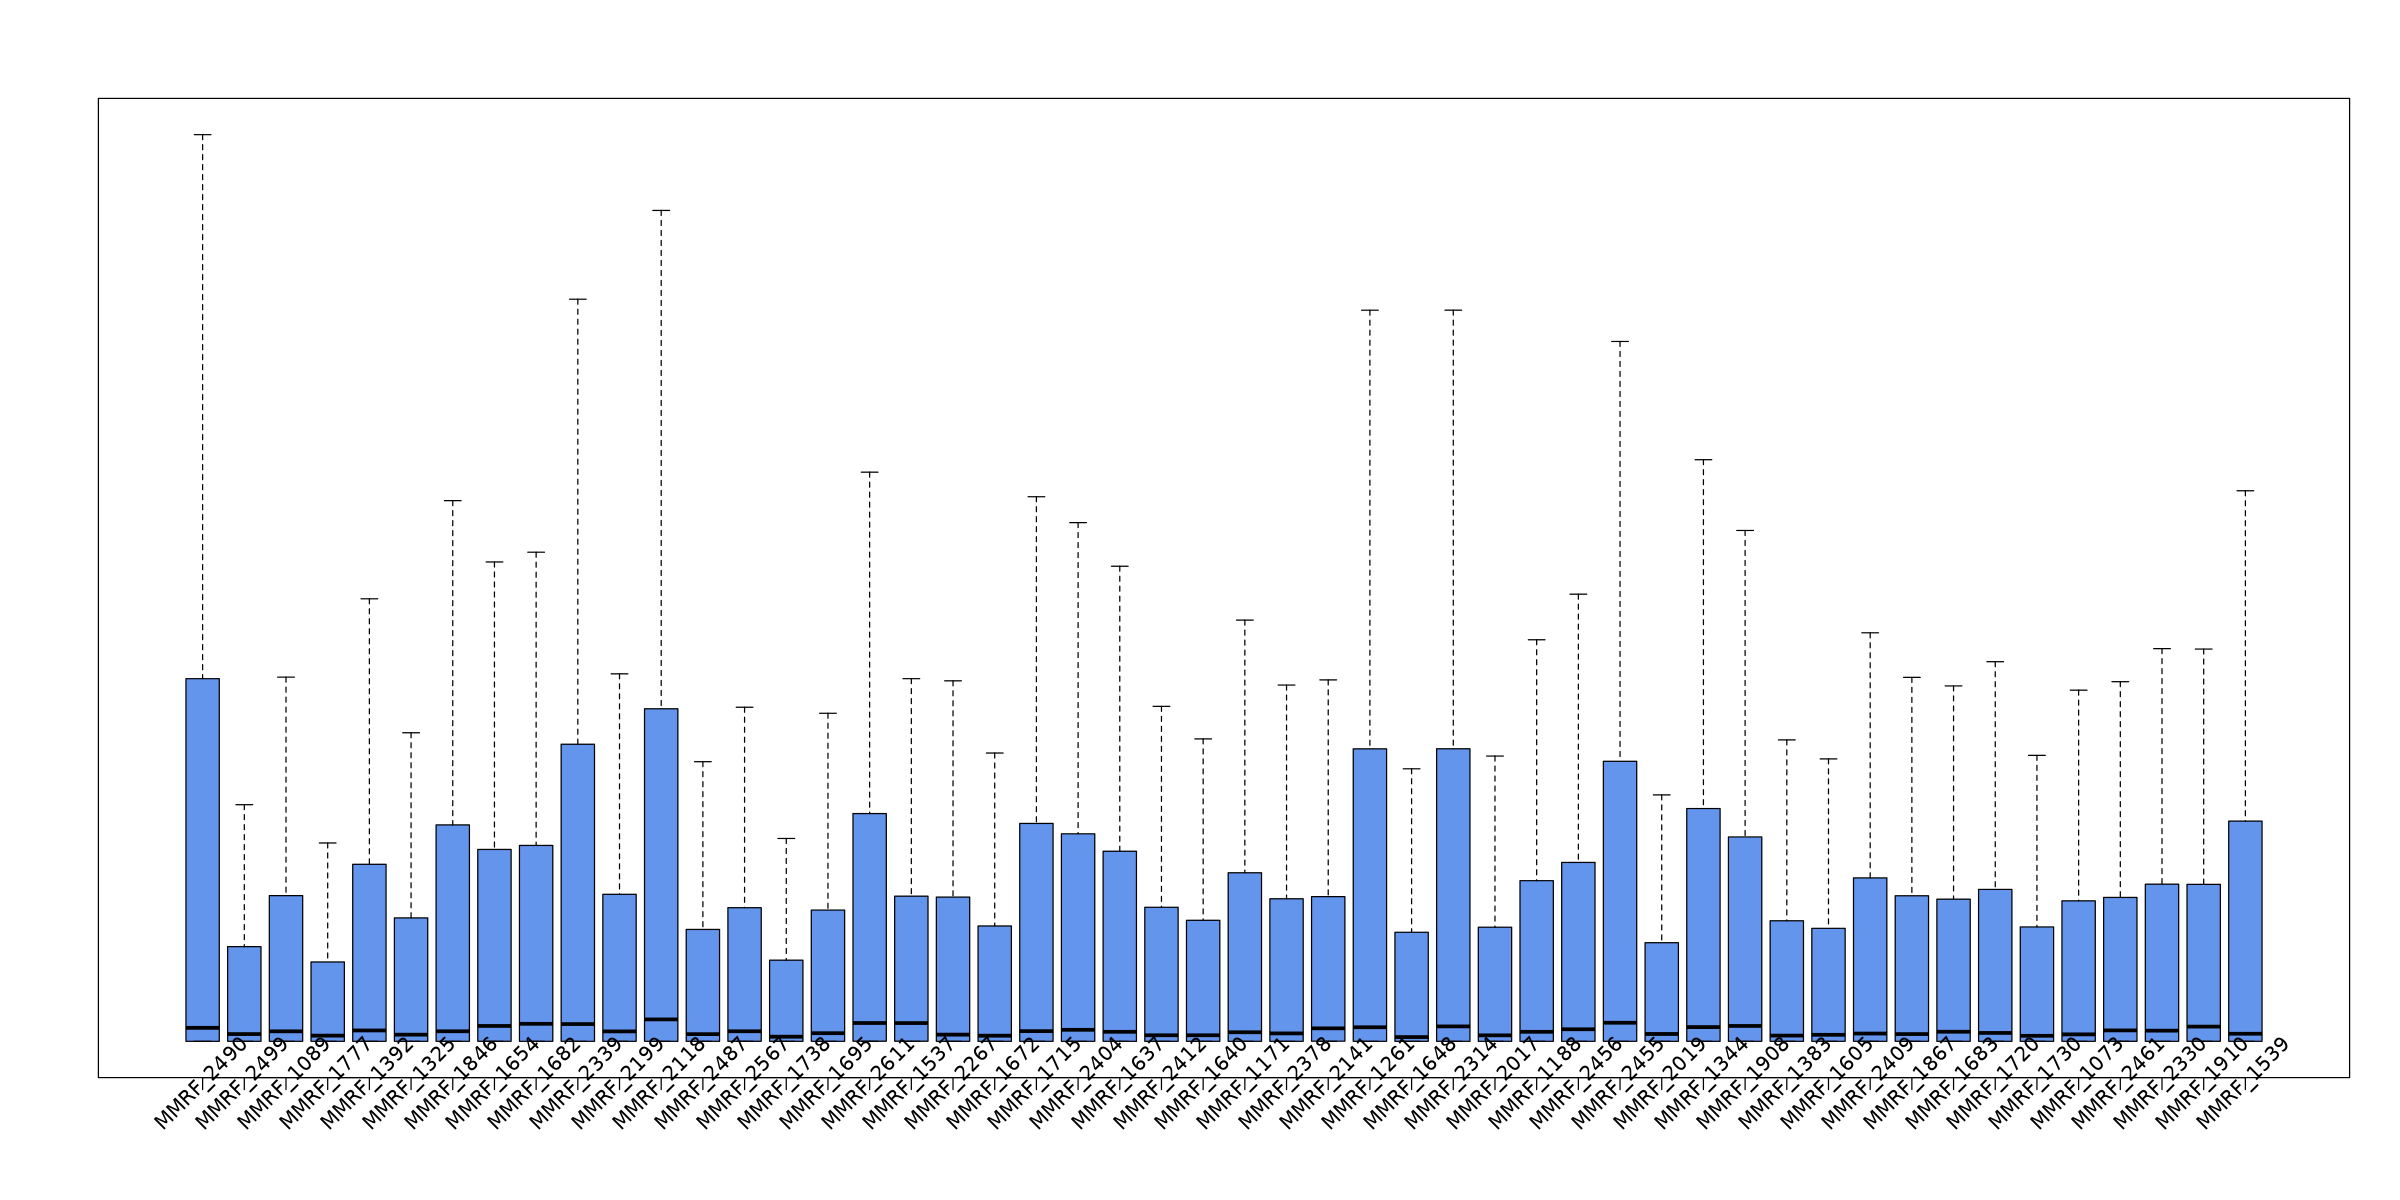

In [33]:
options(repr.plot.width=20, repr.plot.height=10)


# we organized the crowd sourced Multiple Myeloma DREAM Challenge, 
# focusing on predicting high risk, defined as disease progression 
# or death prior to 18 months from diagnosis. 



#----------------- Preprocess the input data

edata = expression_data





# make sure that I all samples that I am going to analyse 
# have also labels
colnames(edata) = gsub("_1_BM","",colnames(edata))
intersect_labels = intersect(colnames(edata),annot_data$Patient)
edata_m = edata[, match(intersect_labels, colnames(edata), nomatch = 0)]
annot_data_m = annot_data[match(intersect_labels, annot_data$Patient, nomatch = 0), ]
#sum(colnames(edata_m)==annot_data_m$Patient) == length(colnames(edata_m))

# TODO: color-code it by HR FLAF, and labels 45 degrees
bp <- boxplot(edata_m[,1:50],outline=FALSE,col="cornflowerblue", xaxt = "n", yaxt = "n")
tick <- seq_along(bp$names)
axis(1, at = tick, labels = FALSE)
text(tick, par("usr")[3] - 0.3, bp$names, srt = 45, xpd = TRUE)

#library(reshape2)
#mt = melt(edata_m[,1:50])
#ggplot(mt, aes(x = variable, y = value)) +
#  geom_boxplot()
#print(head(edata_m[,1:50]))



In [88]:
print(head(annot_data$D_ISS))
a = as.factor(as.character(annot_data$D_ISS))
levels(a) <- list("I"="1","II"="2","III"="3")
annot_data$D_ISS = a
head(annot_data)

[1] 1 1 1 1 2 1


,Study,Patient,D_Age,D_Gender,D_OS,D_OS_FLAG,D_PFS,D_PFS_FLAG,D_ISS,PatientType,⋯,CYTO_predicted_feature_10,CYTO_predicted_feature_11,CYTO_predicted_feature_12,CYTO_predicted_feature_13,CYTO_predicted_feature_14,CYTO_predicted_feature_15,CYTO_predicted_feature_16,CYTO_predicted_feature_17,CYTO_predicted_feature_18,HR_FLAG
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<fct>,<chr>,⋯,<int>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,MMRF,MMRF_1021,54,Female,1575,0,623,1,I,NewlyDiagnosed,⋯,0,NA,0,0,0,0,0,0,0,FALSE
2,MMRF,MMRF_1029,46,Male,995,0,995,0,I,NewlyDiagnosed,⋯,NA,NA,0,0,0,0,0,0,0,FALSE
3,MMRF,MMRF_1030,65,Female,1572,0,1572,0,I,NewlyDiagnosed,⋯,NA,NA,0,0,0,1,0,0,0,FALSE
4,MMRF,MMRF_1031,62,Male,1581,0,1329,1,I,NewlyDiagnosed,⋯,NA,NA,0,0,0,0,0,0,0,FALSE
5,MMRF,MMRF_1032,76,Male,934,1,908,1,II,NewlyDiagnosed,⋯,NA,NA,0,0,0,0,0,0,0,FALSE
6,MMRF,MMRF_1033,64,Male,1525,0,218,1,I,NewlyDiagnosed,⋯,NA,NA,0,0,0,0,0,0,0,TRUE


In [10]:
#----------------- Filtering data and scaling

# Since taking a log seems to work to tame the extreme values, 
# we do that below and also add 1 pseudo-count to be able to deal with 0 values
gexp=log10(edata_m+1)

# transpose the data set
tgexp <- t(gexp)

library(caret)
# remove near zero variation for the columns at least 85% of the values are the same
# this function creates the filter but doesn't apply it yet
nzv=preProcess(tgexp, method="nzv", uniqueCut = 15)

# apply the filter using "predict" function
# return the filtered dataset and assign it to nzv_tgexp variable
nzv_tgexp=predict(nzv,tgexp)

#anyNA(nzv_tgexp) # check if there are NA values


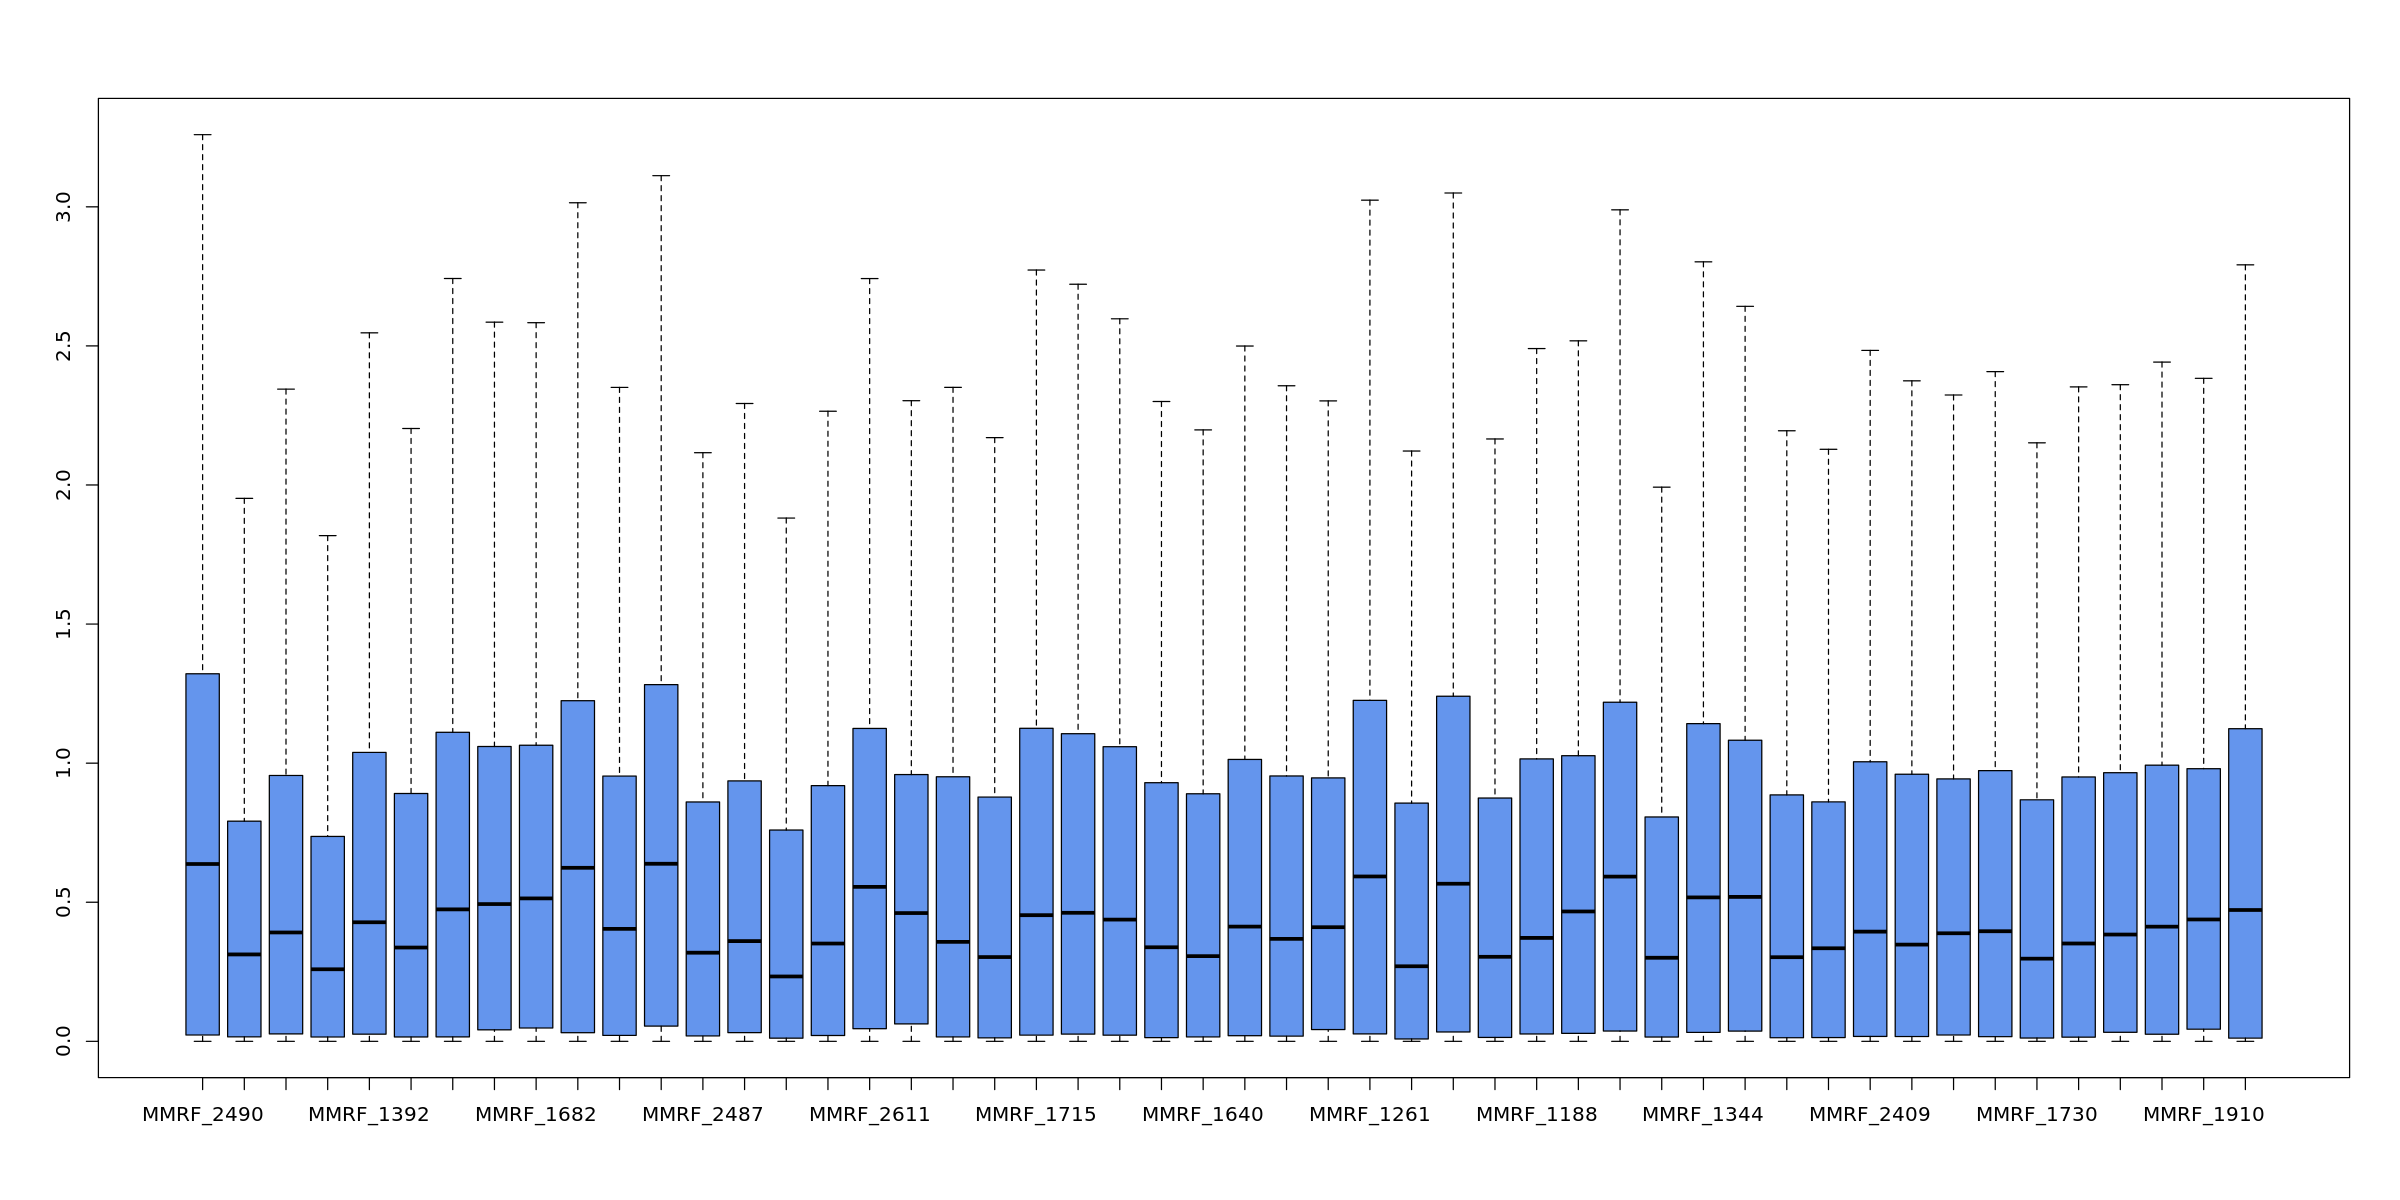

In [11]:
# check if there are NA values in the expression matrix
if(anyNA(nzv_tgexp)) print("There are NAs in the expression matrix")

# show 
nzv_gexp = t(nzv_tgexp)
boxplot(nzv_gexp[,1:50],outline=FALSE,col="cornflowerblue")



Clustering
---------------------





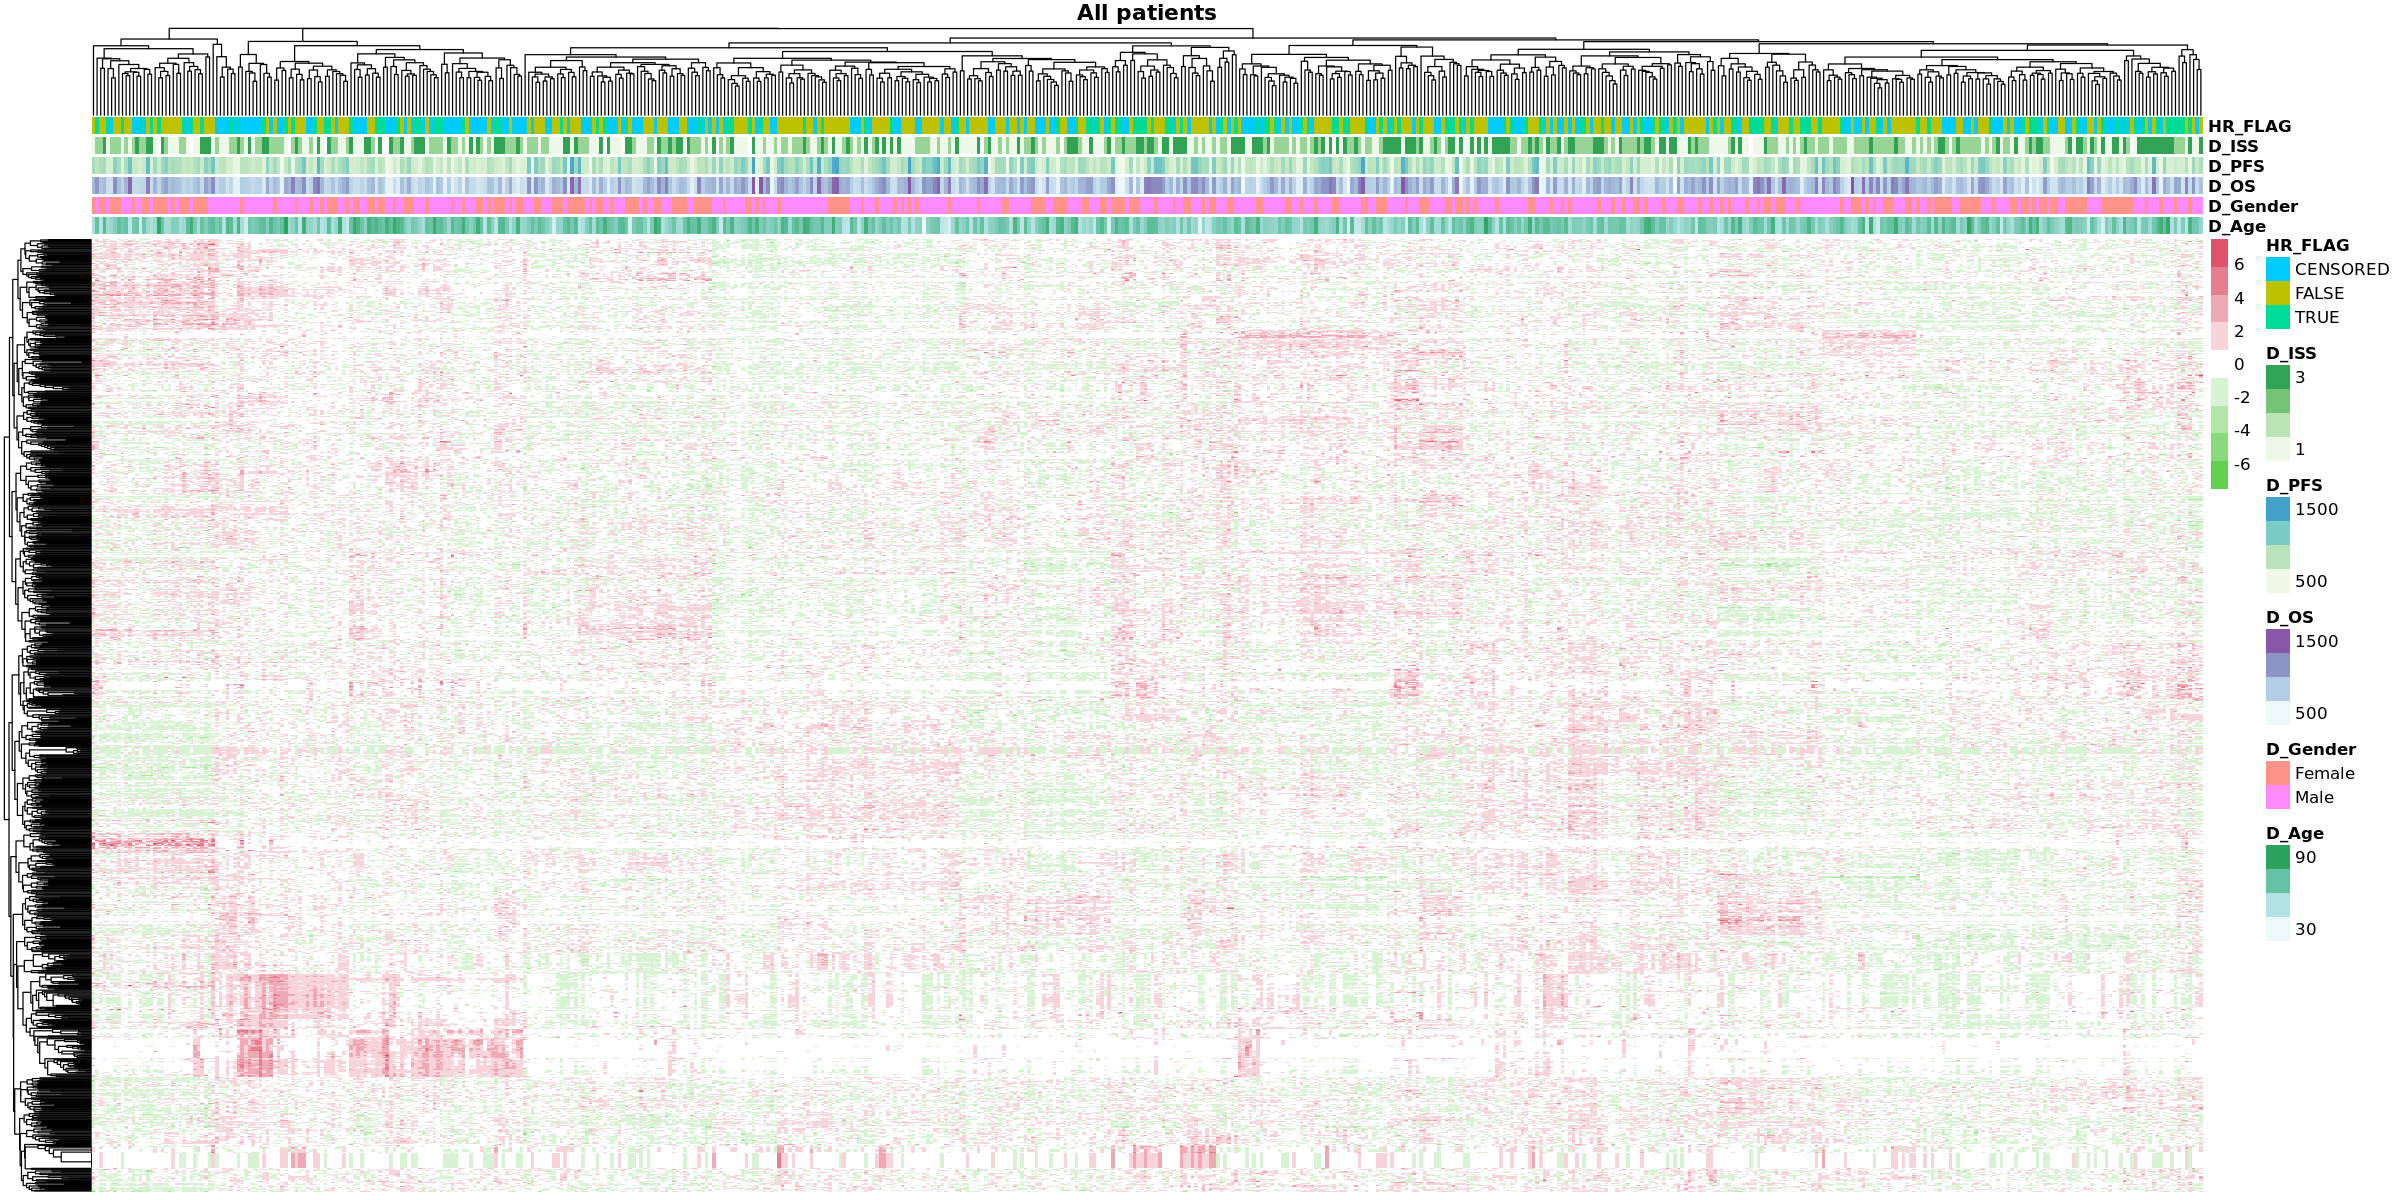

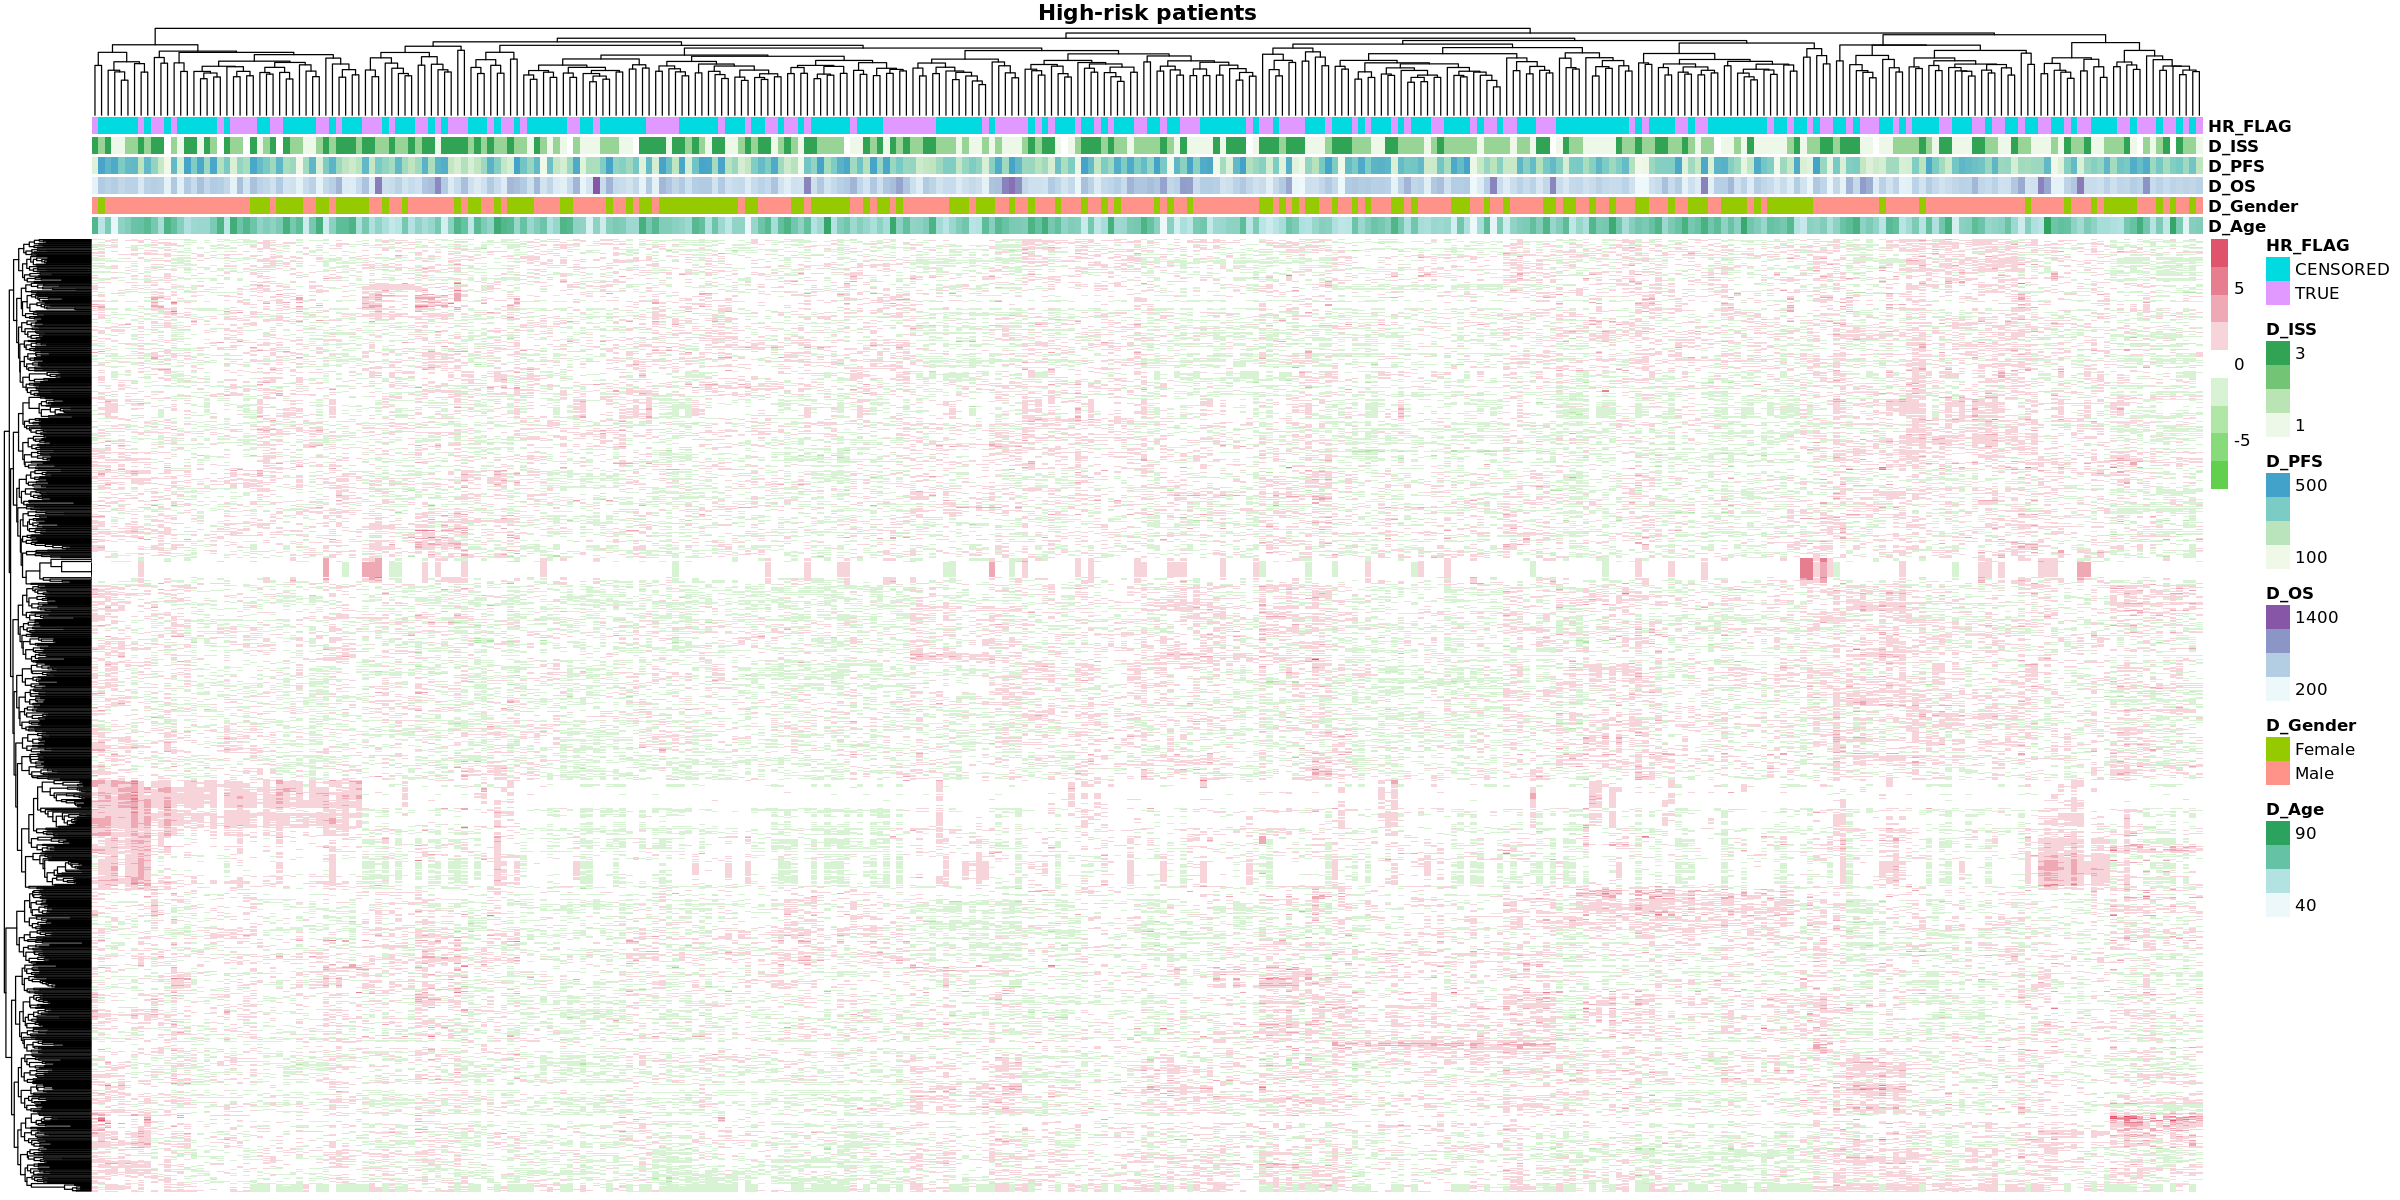

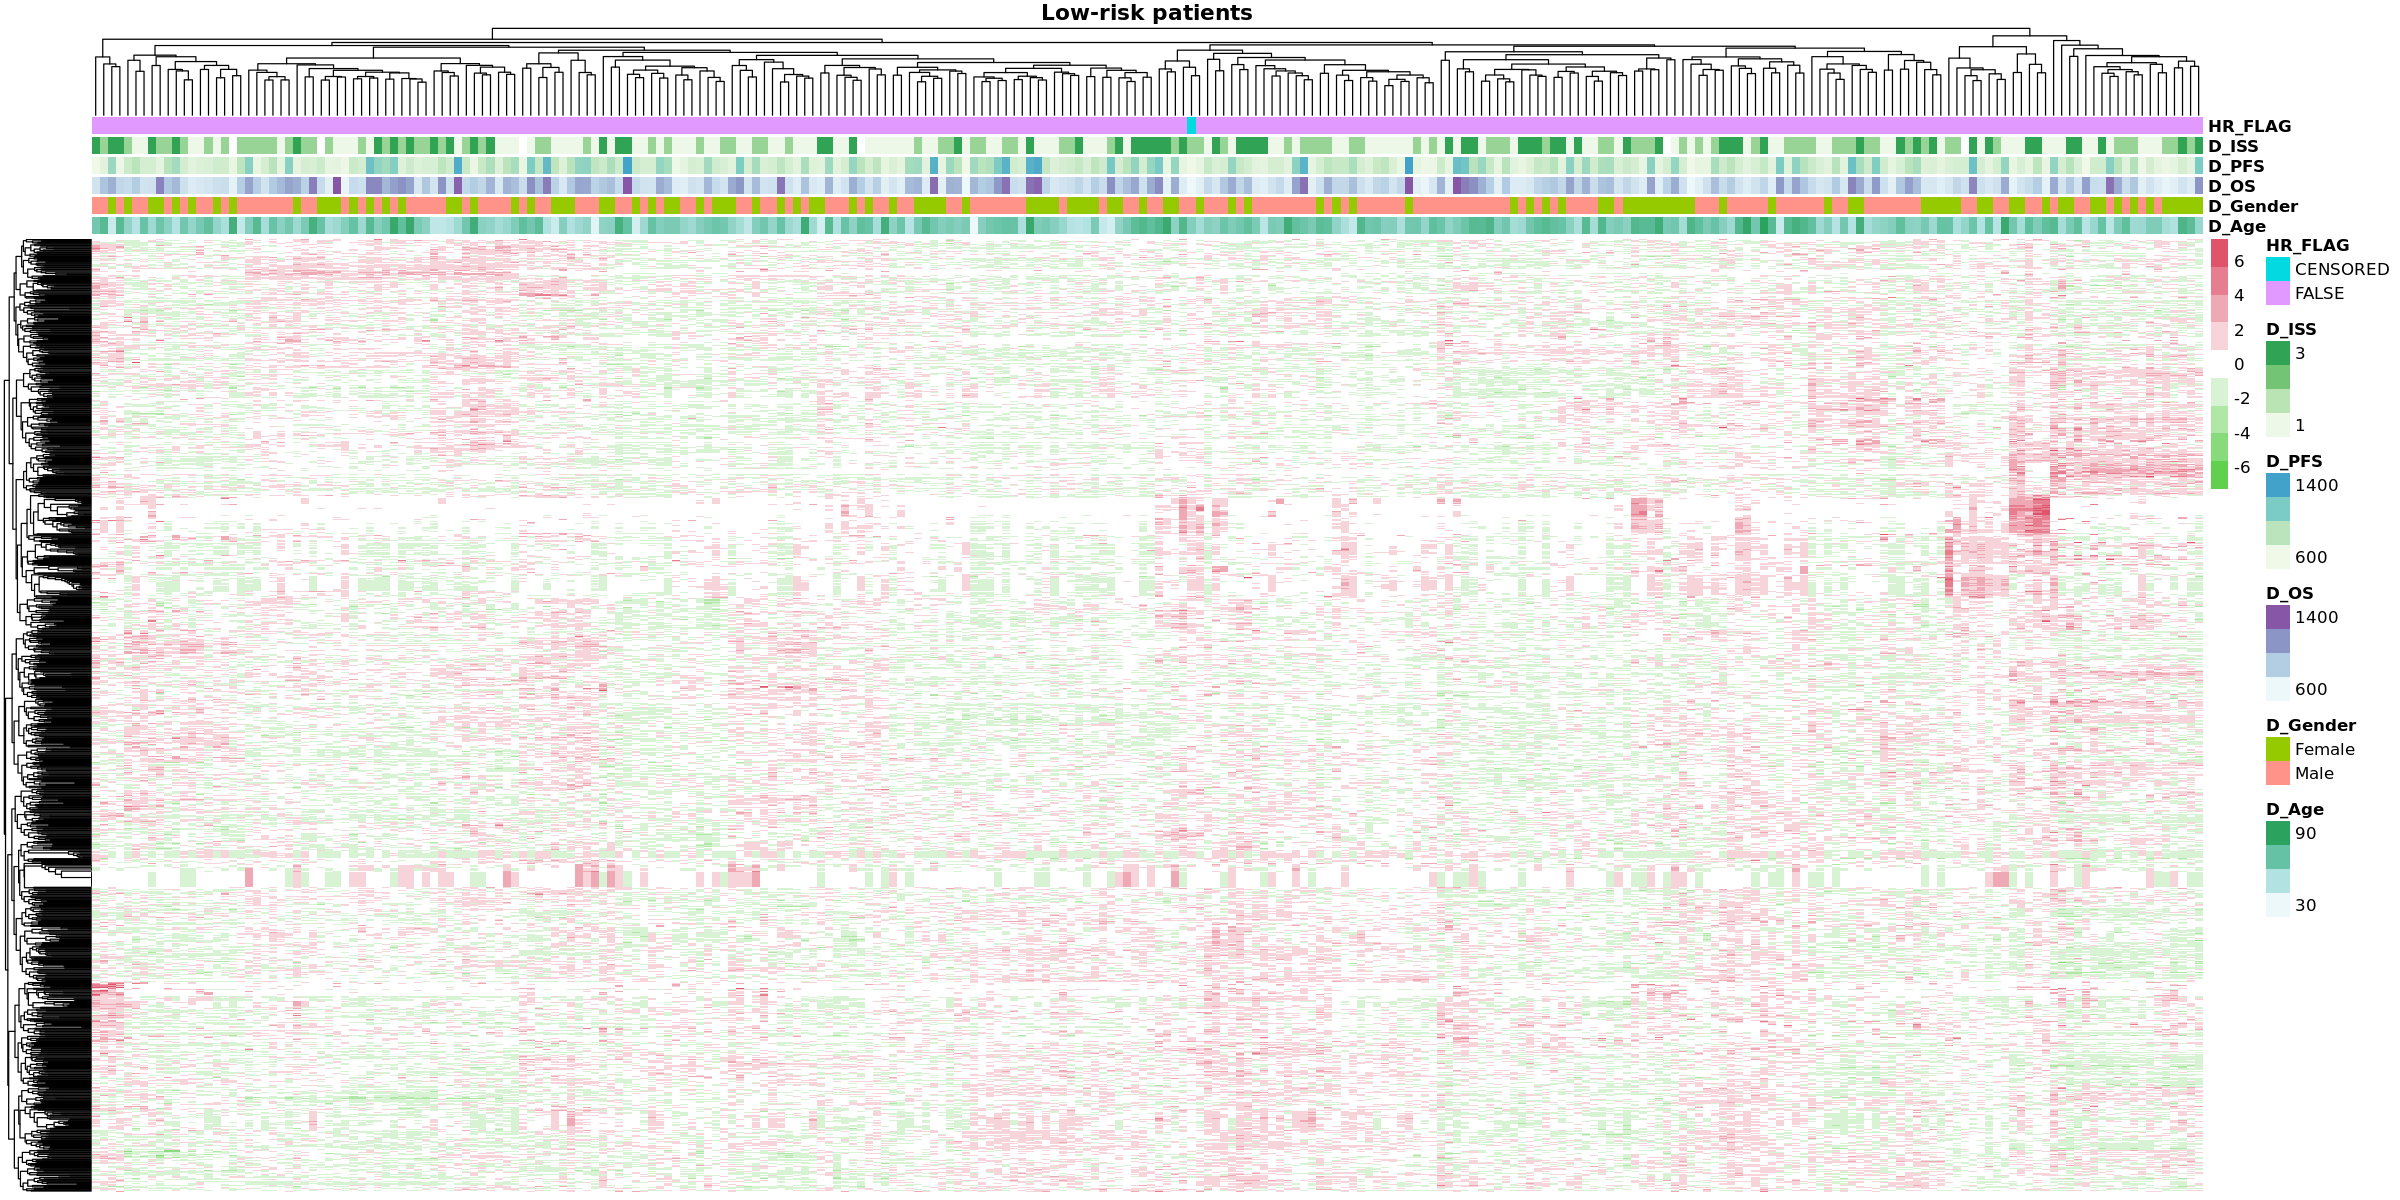

In [34]:
# Let’s select the top 1000 most variable genes among the samples.
options(repr.plot.width=20, repr.plot.height=10)


library(pheatmap)

#compute the variance of each gene across samples
V <- apply(nzv_gexp, 1, var)
#sort the results by variance in decreasing order 
#and select the top 100 genes 
selectedGenes <- names(V[order(V, decreasing = T)][1:1000])


#Now we can quickly produce a heatmap where samples and genes are clustered.
#library(pheatmap)
#pheatmap(nzv_gexp[selectedGenes,], scale = 'row', show_rownames = FALSE)


annot_sel_col <- c("D_Age", 
                   "D_Gender", 
                   "D_OS",
                   "D_PFS", 
                   "D_ISS", 
                   "HR_FLAG"
                  )
colData <- annot_data_m[which(colnames(annot_data_m) %in% annot_sel_col)]
rownames(colData) = colnames(nzv_gexp)

#print(head(nzv_gexp[selectedGenes,]))
#print(head(colData))

library(dichromat)
colramp = colorRampPalette(c(3,"white",2))(9)

pheatmap(nzv_gexp[selectedGenes,], 
         scale = 'row', 
         show_rownames = FALSE, 
         show_colnames = FALSE, 
         annotation_col = colData,
         col=colramp,
         main="All patients")


# Plot newly classified patients that relapsed or died before 18 months (including censored)
pheatmap(nzv_gexp[selectedGenes,which(colData$D_PFS<547.501)], 
         scale = 'row', 
         show_rownames = FALSE, 
         show_colnames = FALSE, 
         annotation_col = colData[which(colData$D_PFS<547.501),],
         col=colramp,
         main="High-risk patients")

pheatmap(nzv_gexp[selectedGenes,which(colData$D_PFS>=547.501)], 
         scale = 'row', 
         show_rownames = FALSE, 
         show_colnames = FALSE, 
         annotation_col = colData[which(colData$D_PFS>=547.501),],
         col=colramp,
        main="Low-risk patients")


# https://rviews.rstudio.com/2017/09/25/survival-analysis-with-r/
# https://www.biostars.org/p/344233/
# https://cran.r-project.org/web/packages/glmnet/vignettes/Coxnet.pdf
# https://compgenomr.github.io/book/gene-expression-analysis-using-high-throughput-sequencing-technologies.html
# https://medium.com/towards-data-science/five-tips-on-survival-analysis-for-a-data-scientist-ba9fd97cbb2d
# https://www.randomforestsrc.org/articles/getstarted.html
# https://bioconnector.github.io/workshops/r-survival.html#tcga
# https://rviews.rstudio.com/2017/09/25/survival-analysis-with-r/
# https://www.biostars.org/p/344233/

In [74]:

#annot_sel_col <- c("D_Age", "D_Gender", "D_OS", "D_PFS", "D_ISS", "HR_FLAG")
#colData <- annot_data_m[which(colnames(annot_data_m) %in% annot_sel_col)]
#head(colData)
#head(annot_data_m)
library(survival)
data(CoxExample)
x <- CoxExample$x
y <- CoxExample$y
y[1:5, ]
head(x)

time,status
1.76877757,1
0.54528404,1
0.04485918,0
0.85032298,0
0.61488426,1


-0.8767670,-0.6135224,-0.56757380,0.6621599,1.82218019,-1.0906678,-0.33186564,3.6754612,0.24580798,1.1382203,⋯,0.8699009,-0.4862156,0.23313891,-0.8902209,1.5371081,0.3620787,-0.05175784,-0.1783899,0.9447754,1.77496688
-0.7463894,-1.7519457,0.28545898,1.1392105,0.80178007,1.8501985,0.30663005,-1.3729036,-0.03249051,0.7477848,⋯,-0.4429407,-0.1356272,0.17755123,-0.1209084,1.0110951,0.9778248,0.90526762,-1.4243355,-0.7334893,-0.05692325
1.3759148,-0.2641132,0.88727408,0.3841870,0.05751801,-1.0917341,0.82119791,2.2960618,-0.44769567,-0.3046003,⋯,0.3925106,1.1122054,0.00555102,-1.4621795,-1.2998127,-2.7680914,-0.16716127,-0.6997792,0.9285742,-1.56113648
0.2375820,0.7859162,-0.89670281,-0.8339338,-0.58237643,0.1874136,-0.58595131,0.4762090,-0.60580025,-1.2703322,⋯,-0.8136730,-1.1984657,0.74974928,-0.9831296,2.0045957,-0.5707114,-0.23549099,0.9390039,0.3634077,0.54857540
0.1086275,0.4665686,-0.57637261,1.7041314,0.32750715,-0.1211972,0.88537209,0.4505604,0.58878157,0.5504976,⋯,0.1603489,-1.0625900,1.71650170,-0.2222816,0.7853629,-0.6134820,1.26367728,-1.8008181,-1.5882571,1.00869790
1.2027213,-0.4187073,-0.05735193,0.5948491,0.44328682,-0.1191545,0.08097645,0.1645867,0.35648515,0.7186709,⋯,-0.4237433,-0.5998976,-0.72813688,-1.7928807,-1.3879823,-1.7141769,-0.19156886,-0.9339565,0.2559535,-1.38194415


In [38]:
options(repr.plot.width=7, repr.plot.height=7)


# PCA
# Let’s make a PCA plot to see the clustering of replicates as a scatter plot in two dimensions 

library(stats)
library(ggfortify); library(ggplot2)
#transpose the matrix 
#M <- t(nzv_gexp[selectedGenes,])
#M <- t(nzv_gexp)

#nzv_gexp_centered2 = t(nzv_gexp) - colMeans(nzv_gexp)

# transform the counts to log2 scale 
#M <- log2(M + 1)
#compute PCA 
pcaResults <- prcomp(t(nzv_gexp), center = TRUE)

#plot PCA results making use of ggplot2's autoplot function
#ggfortify is needed to let ggplot2 know about PCA data structure.

annot_data_m$D_ISS = as.factor(annot_data_m$D_ISS)

#autoplot(pcaResults)

autoplot(pcaResults, data = annot_data_m, colour = 'D_Gender')
autoplot(pcaResults, data = annot_data_m, colour = 'D_ISS')
autoplot(pcaResults, data = annot_data_m, colour = 'D_Age')
autoplot(pcaResults, data = annot_data_m, colour = 'HR_FLAG')



ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 582, 19728


In [113]:
#print(pcaResults$)
#dim(pcaResults$x)
#print(dim(annot_data_m))


Correct gene expression data using the ComBat algorithm
------------------------------------------------

Looking at the results of the hierarchical custering and PCA above, I got inspired to remove batch effects and other unwanted variation.



In [16]:
#edata = expression_data[rowMeans(expression_data) > 100,]
# to be ona scale thats easier to work with
#edata = log2(edata + 1)
# if we dont center the data, if we dont remove rowmeans of the center, the column means of data
# then the first singual value will always be the mean level
# since that will always explain the most variation in genomics experiment
# we want to see variation between sample or between genes
#edata_centered = edata - rowMeans(edata) 
#svd1 = svd(edata_centered)
#names(svd1)

In [ ]:
# try KNN, Support Vector Machines and Ensemble Methods like Random Forests or Gradient Boosting

In [40]:
#head(annot_data_m)
#head(nzv_gexp)


head(nzv_gexp)
head(annot_data_m)


,MMRF_2490,MMRF_2499,MMRF_1089,MMRF_1777,MMRF_1392,MMRF_1325,MMRF_1846,MMRF_1654,MMRF_1682,MMRF_2339,⋯,MMRF_1694,MMRF_2143,MMRF_1847,MMRF_1787,MMRF_1048,MMRF_2437,MMRF_1497,MMRF_1700,MMRF_1918,MMRF_1670
1,1.28760916,1.20922002,0.6055604,1.4224503,1.494619263,1.3290295,0.9017285,1.16135602,1.39442891,1.4311932,⋯,1.287057868,1.311817412,0.06494817,1.4434773,0.5773160,0.93968495,1.267303171,1.5506979,0.68002532,0.9073297
2,0.03586829,1.15271631,0.4475859,0.9531370,0.223500094,0.2959465,0.1371869,0.19506650,0.32903565,0.7561871,⋯,0.080082196,1.718785590,0.29307602,0.1274822,0.1422117,0.67587545,0.477383200,0.3099792,0.07180582,1.6629683
3,0.00000000,0.00000000,0.0000000,0.0000000,0.004389781,0.0000000,0.0000000,0.01877491,0.01749199,0.0000000,⋯,0.006782812,0.007659972,0.01376306,0.0000000,0.0000000,0.00000000,0.006225852,0.0000000,0.00000000,0.0000000
9,0.60888530,0.25615853,0.1459316,0.3294752,0.197083357,0.3610305,0.4023078,0.35247002,0.37007061,0.7588930,⋯,0.654936614,0.335921035,0.56398747,0.3879128,0.6231397,0.24251708,0.140834741,0.2604261,0.50906267,0.5228093
14,1.89739394,1.22952570,1.2497852,1.1937227,1.472598495,1.4228786,1.7294005,1.59766996,1.50671874,1.6473155,⋯,1.681781056,1.390871547,1.77674040,1.5509911,1.4989181,1.24721197,1.013765538,1.4738182,1.60372016,1.6244172
15,0.29066622,0.09195663,0.1732670,0.1058857,0.510837122,0.1478117,0.2043761,0.22776565,0.10280746,0.3660679,⋯,0.121028715,0.076309409,0.03926651,0.1504642,0.1069408,0.01349075,0.082566014,0.1686789,0.08655131,0.1019741


,Study,Patient,D_Age,D_Gender,D_OS,D_OS_FLAG,D_PFS,D_PFS_FLAG,D_ISS,PatientType,⋯,CYTO_predicted_feature_10,CYTO_predicted_feature_11,CYTO_predicted_feature_12,CYTO_predicted_feature_13,CYTO_predicted_feature_14,CYTO_predicted_feature_15,CYTO_predicted_feature_16,CYTO_predicted_feature_17,CYTO_predicted_feature_18,HR_FLAG
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<fct>,<chr>,⋯,<int>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
529,MMRF,MMRF_2490,81,Female,349,1,91,1,3,NewlyDiagnosed,⋯,NA,NA,0,0,0,0,0,0,0,TRUE
532,MMRF,MMRF_2499,55,Female,304,0,304,0,1,NewlyDiagnosed,⋯,0,NA,0,0,0,0,0,0,0,CENSORED
18,MMRF,MMRF_1089,61,Male,1035,0,881,0,3,NewlyDiagnosed,⋯,NA,NA,0,0,0,1,0,0,0,FALSE
252,MMRF,MMRF_1777,67,Female,778,0,750,0,1,NewlyDiagnosed,⋯,NA,NA,0,0,0,0,0,0,0,FALSE
103,MMRF,MMRF_1392,41,Male,769,1,769,1,1,NewlyDiagnosed,⋯,NA,NA,0,0,0,0,0,0,0,FALSE
77,MMRF,MMRF_1325,58,Female,1082,0,1082,0,3,NewlyDiagnosed,⋯,0,NA,0,0,0,0,0,0,0,FALSE


In [41]:
#------------------------- Regularized Cox Regression
library(glmnet);
library(survival);

# filter patients that
#samples_hrflag = annot_data_m$HR_FLAG==TRUE | annot_data_m$HR_FLAG=="CENSORED"

#annot_data_mfl=annot_data_m[which(samples_hrflag),]
#nzv_gexp_fl = nzv_gexp[,which(samples_hrflag)]


# x must be an n × p matrix of covariate values
#— each row corresponds to a patient and each column a covariate. y is an n × 2 matrix, with a column
#"time" of failure/censoring times, and "status" a 0/1 indicator, with 1 meaning the time is a failure
#time, and 0 a censoring time
#x_regcox <- as.matrix(t(nzv_gexp_fl))
#y_regcox <- as.matrix(data.frame(time = annot_data_mfl$D_OS,
#                       status = ifelse(annot_data_mfl$HR_FLAG==TRUE, 1, 0)
#                       ))

#fit_regcox <- glmnet(as.matrix(x_regcox), as.matrix(y_regcox), family = "cox")
#plot(fit_regcox)
#coef(fit, s = 0.05)
#set.seed(123)
#cvfit_regcox <- cv.glmnet(x_regcox, y_regcox, family = "cox", type.measure = "C")
#plot(cvfit_regcox)




[1] 0.002151318

[1] 0.09755967

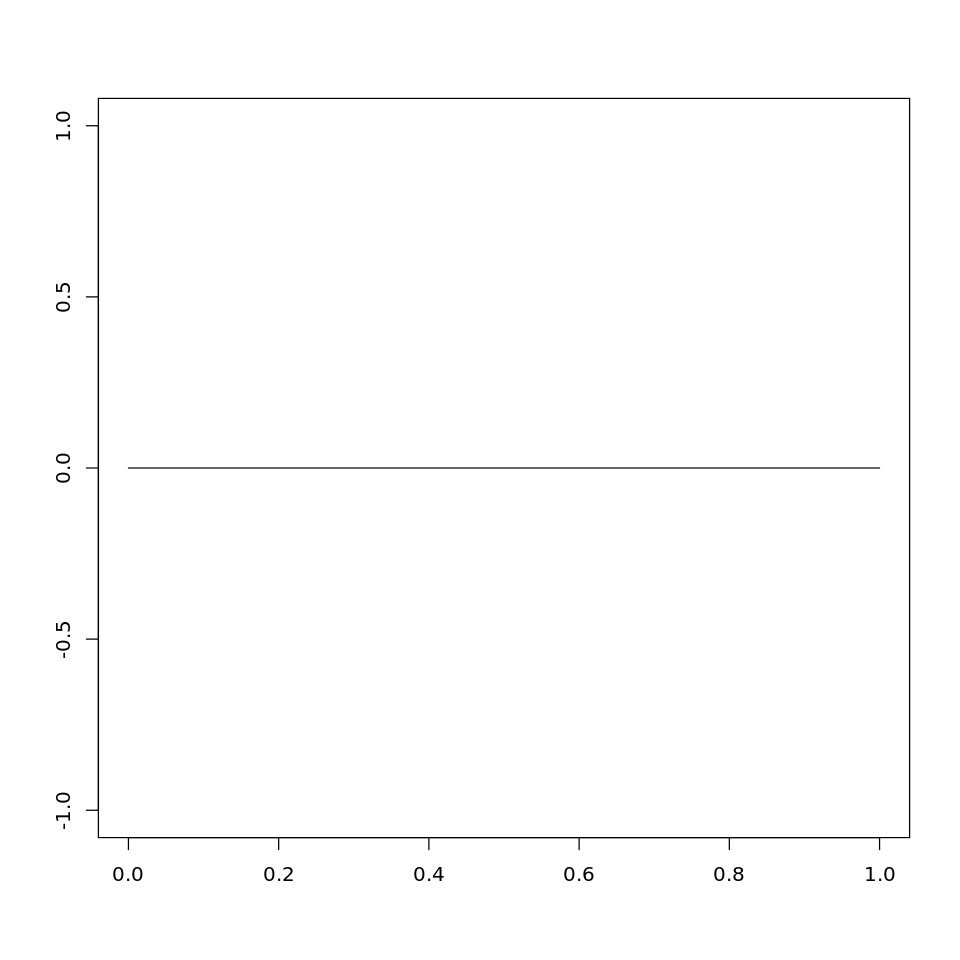

In [51]:
options(repr.plot.width=8, repr.plot.height=8)
#plot(cvfit)
cvfit_regcox$lambda.min
cvfit_regcox$lambda.1se
# visualize the survival curves from the model
#survival::survfit(fit_regcox, s = 0.05, x = x, y = y)

#print(survival::Surv(y_regcox))
#print(fit_regcox)
plot(survival::survfit(fit_regcox, s = 0.05, x = x_regcox, y = survival::Surv(y_regcox)))



[1] "coxnet" "glmnet"
            [,1]       [,2]       [,3]       [,4]       [,5]       [,6]
[1,] -0.89691455  1.0744594  0.2979836 -0.3181198 -0.2140756 -0.4597894
[2,]  0.18484918  0.2605978  0.0000000 -0.3154903  0.0000000  0.6179261
[3,]  1.58784533  0.0000000  2.8708974  0.8843223 -1.0142618 -0.7204224
[4,] -1.13037567  0.0000000  0.2187100 -1.8854213 -0.8291451  0.0000000
[5,] -0.08025176 -0.8621983 -0.9665543  0.0000000  0.0000000  0.2163245
[6,]  0.13242028  2.0480403  0.3838382  0.7905447 -0.2385101  0.0000000
           [,7]       [,8]       [,9]        [,10]      [,11]       [,12]
[1,] -1.1150718 0.00000000 -0.6290441  0.000000000  0.4662004  0.42896236
[2,]  0.0000000 0.00000000 -2.2743445  1.092478657  0.9546664  0.00000000
[3,]  0.0000000 0.00000000  0.0000000  0.002880342 -0.9472064 -1.27942267
[4,] -0.6540889 1.49970370 -0.2136880  0.000000000  0.0000000  0.09734053
[5,]  1.1787163 0.06957437  0.0000000 -0.067891188 -0.8308823 -0.62939109
[6,]  0.9515165 0.00000000 -0.

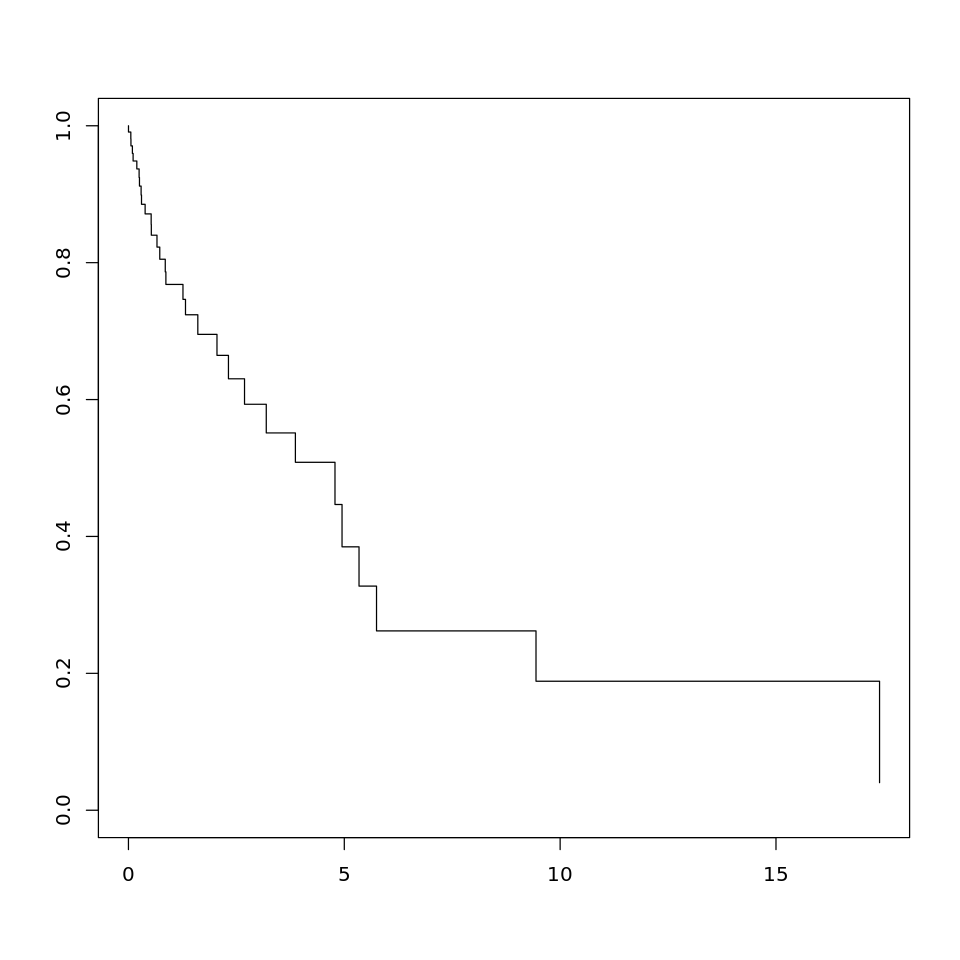

In [44]:
set.seed(2)
nobs <- 100; nvars <- 15
xvec <- rnorm(nobs * nvars)
xvec[sample.int(nobs * nvars, size = 0.4 * nobs * nvars)] <- 0
x <- matrix(xvec, nrow = nobs)
beta <- rnorm(nvars / 3)
fx <- x[, seq(nvars / 3)] %*% beta / 3
ty <- rexp(nobs, exp(fx))
tcens <- rbinom(n = nobs, prob = 0.3, size = 1)
y <- survival::Surv(ty, tcens)
fit1 <- glmnet(x, y, family = "cox")

# survfit object for Cox model where lambda = 0.1
print(class(fit1))
print(head(x))
print(head(y))
sf1 <- survival::survfit(fit1, s = 0.1, x = x, y = y)
plot(sf1)

Baseline models: age, ISS, and age + ISS
---------------------------------------------------------

Baseline models were Cox proportional hazards models where PFS was the response variable and age, ISS, or both age and ISS were explanatory variables. Continuous risk predictions scores of each sample were thresholded to create high risk classifications. The threshold of a given model was calculated by generating sample level  predictions in the training data. The threshold was defined as the cutpoint that maximized the logrank statistic comparing above and below the threshold to their true high-risk status. Continuous predictions for validation data were computed by applying the above trained Cox proportional hazards model to them. These values were dichotomized into high and low risk according to whether the prediction was above or below, respectively, the threshold.

The baseline predictors were Cox proportional hazard models where progression free survival was modeled on age or ISS or age and ISS together. As comparators these models represent a reasonable lower bound on expected performance of high-risk classifiers. 


estimated cutpoint 
          1.333989 



	Fisher's Exact Test for Count Data

data:  y$high.risk and y$inferred.high.risk
p-value = 4.404e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2404837 0.6187949
sample estimates:
odds ratio 
 0.3846837 


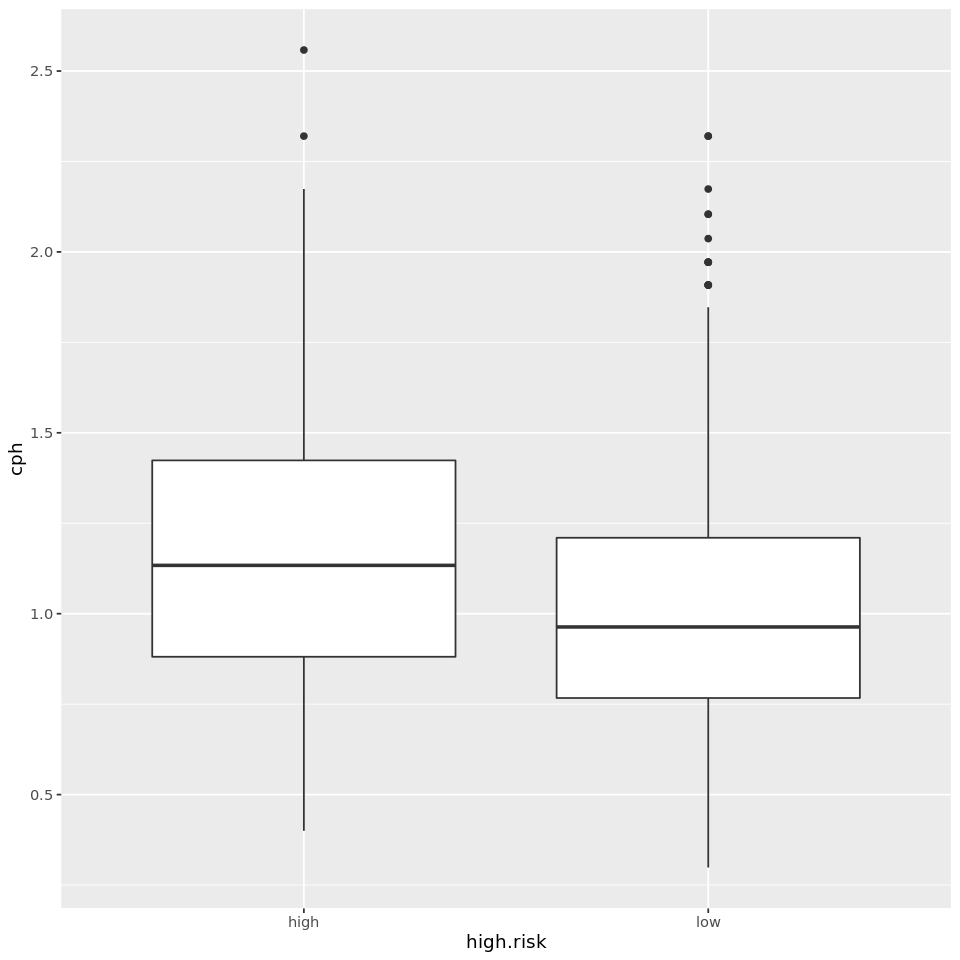

In [72]:
options(repr.plot.width=8, repr.plot.height=8)

#------------------ age
library(glmnet);
library(survival);



coxph.model = function(y, clinical.covariates){

    surv.formula <- as.formula(paste("Surv(time, status)", "~",
                                     paste(clinical.covariates, collapse = " + "), sep = " "))
    cph.fit <- coxph(surv.formula, data = y)

    #print(cph.fit)
    #print(head(y))
    #a = predict(cph.fit, newdata = y, type = "risk")
    #print(a)
    
    pred <- unname(predict(cph.fit, newdata = y, type = "risk"))
    y$cph <- pred

    ## Calculate a threshold for the Cox proportional hazards model                                                                                                                     
    suppressPackageStartupMessages(library(maxstat))
    mt.formula <- as.formula(paste("Surv(time, status)", "~", "cph", sep = " "))
    mt <- maxstat.test(mt.formula, data=data.frame(y), smethod="LogRank", pmethod="none")
    print(mt$estimate)
    
    return(
        list(y = y, 
             fitted.model = cph.fit, 
             threshold = as.numeric(mt$estimate))
        )
    
}

?coxph

y = annot_data_m
y$time = y$D_PFS
y$status = y$D_PFS_FLAG

res = coxph.model(y, "D_Age")
threshold <- res$threshold
y$cph = res$y$cph

y$high.risk <- unlist(apply(y[, c("status", "time")], 1,
                                function(row) ifelse((row[1] == 1) && (row[2] < 18*(365.25/12)), "high", "low")))
y$inferred.high.risk <- y$cph > threshold

#print(head(y))
                            
 fisher.test(y$high.risk, y$inferred.high.risk)
library(ggplot2)
## library(ggbeeswarm)
g <- ggplot(data = y, aes(x = high.risk, y = cph))
g <- g + geom_boxplot()                           
g                          
                            


In [73]:
options(repr.plot.width=8, repr.plot.height=8)

#------------------ AGE
library(glmnet);
library(survival);


coxph.model = function(y, clinical.covariates){

    surv.formula <- as.formula(paste("Surv(time, status)", "~",
                                     paste(clinical.covariates, collapse = " + "), sep = " "))
    cph.fit <- coxph(surv.formula, data = y)
    
    pred <- unname(predict(cph.fit, newdata = y, type = "risk"))
    y$cph <- pred

    ## Calculate a threshold for the Cox proportional hazards model                                                                                                                     
    suppressPackageStartupMessages(library(maxstat))
    mt.formula <- as.formula(paste("Surv(time, status)", "~", "cph", sep = " "))
    mt <- maxstat.test(mt.formula, data=data.frame(y), smethod="LogRank", pmethod="none")
    print(mt$estimate)
    
    return(
        list(y = y, 
             fitted.model = cph.fit, 
             threshold = as.numeric(mt$estimate))
        )
    
}
y = annot_data_m
y$time = y$D_PFS
y$status = y$D_PFS_FLAG

res = coxph.model(y, "D_Age")
threshold <- res$threshold
y$cph = res$y$cph






estimated cutpoint 
          1.333989 


In [ ]:
###############################################

# x must be an n × p matrix of covariate values
#— each row corresponds to a patient and each column a covariate. y is an n × 2 matrix, with a column
#"time" of failure/censoring times, and "status" a 0/1 indicator, with 1 meaning the time is a failure
#time, and 0 a censoring time
#x_regcox <- as.matrix(t(nzv_gexp_fl))
#y_regcox <- as.matrix(data.frame(time = annot_data_mfl$D_OS,
#                       status = ifelse(annot_data_mfl$HR_FLAG==TRUE, 1, 0)
#                       ))
#fit_regcox <- glmnet(as.matrix(x_regcox), as.matrix(y_regcox), family = "cox")
#plot(fit_regcox)
#coef(fit, s = 0.05)
#set.seed(123)
#cvfit_regcox <- cv.glmnet(x_regcox, y_regcox, family = "cox", type.measure = "C")
#plot(cvfit_regcox)

annot_data_mfl$time = annot_data_mfl$D_OS
annot_data_mfl$status =ifelse(annot_data_mfl$HR_FLAG==TRUE, 1, 0)

cox <- coxph(Surv(time, status) ~ D_Age , data = annot_data_mfl)
#print(head(annot_data_mfl))

cox_fit <- survfit(cox)
#plot(cox_fit, main = "cph model", xlab="Days")
autoplot(cox_fit) + ggtitle("Cox proportional hazard model: age") + xlab("Days") + ylab("Survival")

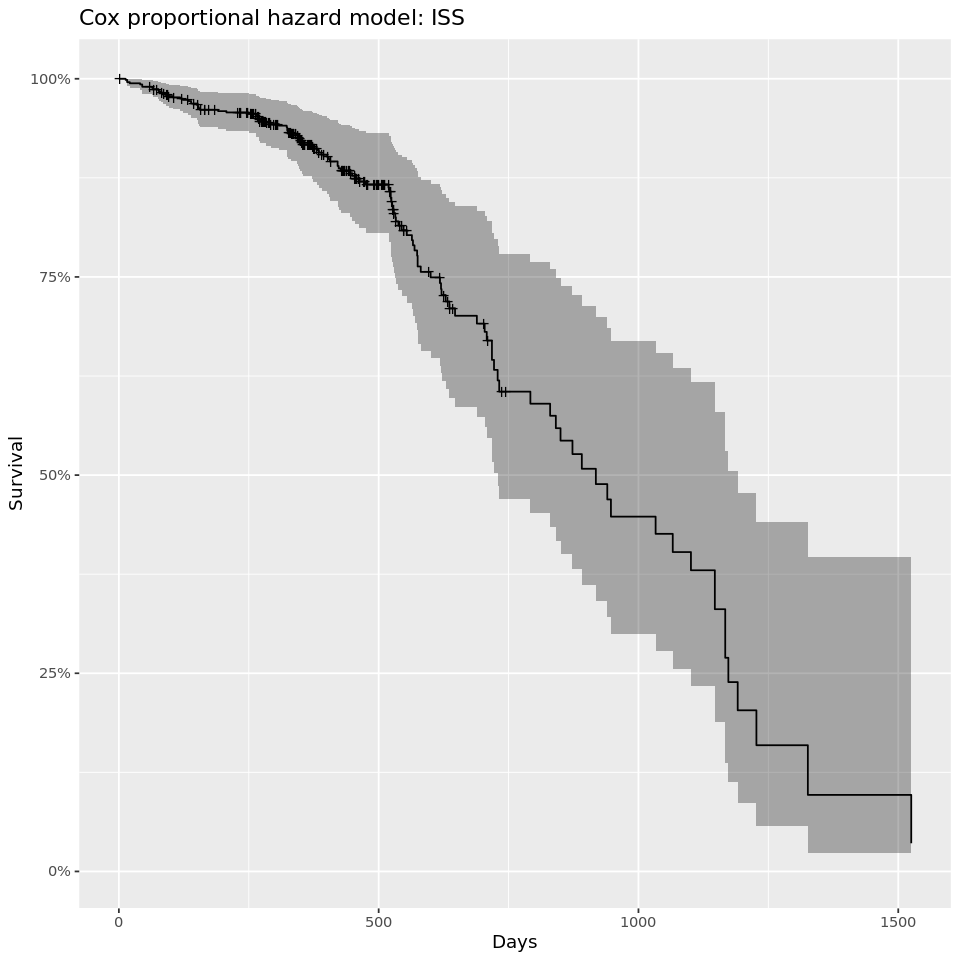

In [76]:
#------------------ ISS
#sfit <- survfit(Surv(times, patient.vital_status)~admin.disease_code, data=clin)
#summary(sfit, times=seq(0,365*5,365))

cox <- coxph(Surv(time, status) ~ D_ISS, data = annot_data_mfl)
#print(head(annot_data_mfl))

cox_fit <- survfit(cox)
#plot(cox_fit, main = "cph model", xlab="Days")
autoplot(cox_fit) + ggtitle("Cox proportional hazard model: ISS") + xlab("Days") + ylab("Survival")


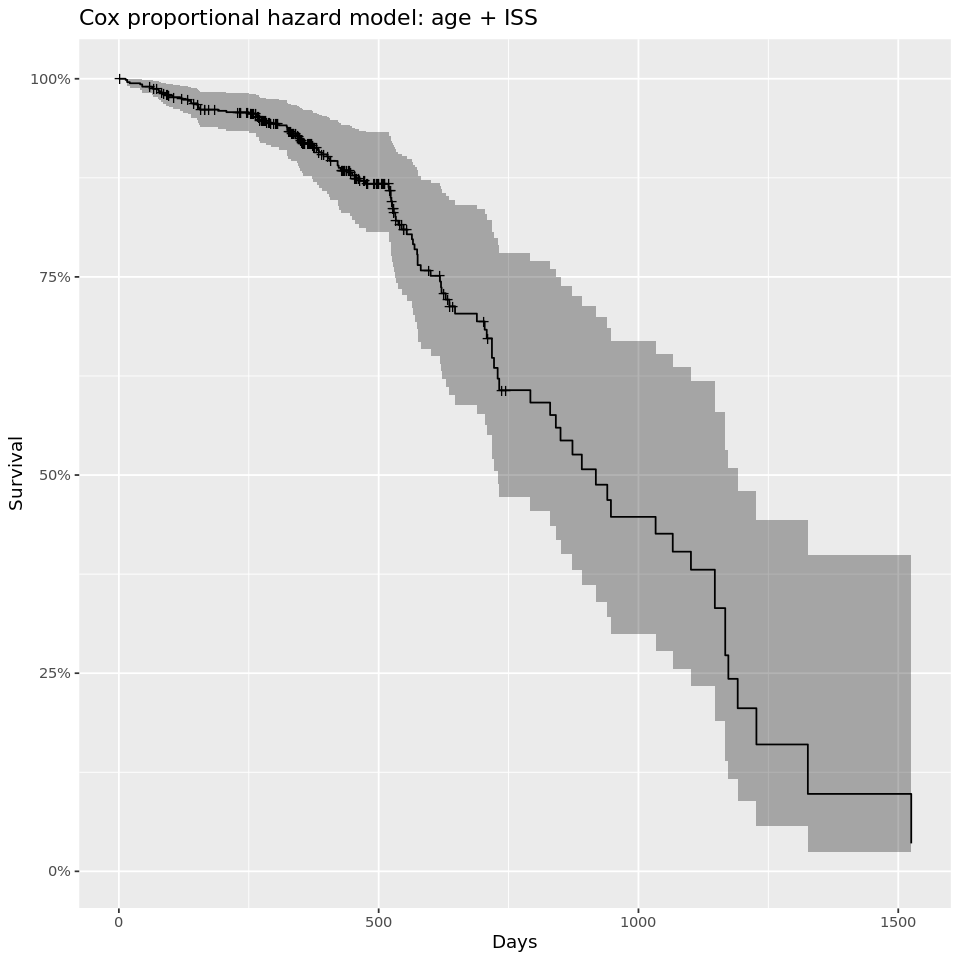

In [77]:
#------------------ age + ISS
cox <- coxph(Surv(time, status) ~ D_Age + D_ISS, data = annot_data_mfl)

cox_fit <- survfit(cox)
autoplot(cox_fit) + ggtitle("Cox proportional hazard model: age + ISS") + xlab("Days") + ylab("Survival")


Cox Proportional Hazards survival model
---------------------------------------------------------


In [52]:
# https://www.biostars.org/p/344233/

library(Biobase)
  library(GEOquery)

  # load series and platform data from GEO
  gset <- getGEO('GSE2990', GSEMatrix =TRUE, getGPL=FALSE)
  x <- exprs(gset[[1]])

  # remove Affymetrix control probes
  x <- x[-grep('^AFFX', rownames(x)),]

  # transform the expression data to Z scores
  x <- t(scale(t(x)))

  # extract information of interest from the phenotype data (pdata)
  idx <- which(colnames(pData(gset[[1]])) %in%
    c('age:ch1', 'distant rfs:ch1', 'er:ch1',
      'ggi:ch1', 'grade:ch1', 'node:ch1',
      'size:ch1', 'time rfs:ch1'))

  metadata <- data.frame(pData(gset[[1]])[,idx],
    row.names = rownames(pData(gset[[1]])))

  # remove samples from the pdata that have any NA value
  discard <- apply(metadata, 1, function(x) any( is.na(x) ))
  metadata <- metadata[!discard,]

  # filter the Z-scores expression data to match the samples in our pdata
  x <- x[,which(colnames(x) %in% rownames(metadata))]

  # check that sample names match exactly between pdata and Z-scores 
  all((colnames(x) == rownames(metadata)) == TRUE)
  ## [1] TRUE

  # create a merged pdata and Z-scores object
  coxdata <- data.frame(metadata, t(x))

  # tidy column names
  colnames(coxdata)[1:8] <- c('Age', 'Distant.RFS', 'ER',
    'GGI', 'Grade', 'Node',
    'Size', 'Time.RFS')

  # prepare phenotypes
  coxdata$Distant.RFS <- as.numeric(coxdata$Distant.RFS)
  coxdata$Time.RFS <- as.numeric(gsub('^KJX|^KJ', '', coxdata$Time.RFS))
  coxdata$ER <- factor(coxdata$ER, levels = c(0, 1))
  coxdata$Grade <- factor(coxdata$Grade, levels = c(1, 2, 3))



Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)

Found 1 file(s)

GSE2990_series_matrix.txt.gz



[1] TRUE

In [57]:
print(head(coxdata))

          Age Distant.RFS ER       GGI Grade Node Size Time.RFS  X1007_s_at
GSM65752   40           0  0   2.48005     3    0  1.2     2280  0.61091071
GSM65753   46           0  1 -0.633592     1    0  1.3     2675  0.66320599
GSM65754 KJ67           1  1  -1.02972     1    0    6      426  0.39016262
GSM65755   41           1  1   1.04395     3    0  3.3      182 -0.01019652
           X1053_at   X117_at   X121_at X1255_g_at    X1294_at  X1316_at
GSM65752  0.8032178 0.9576007 0.3236762 0.20730041 -0.57647252 0.5170007
GSM65753  0.1252538 0.4033209 0.1810776 0.08599057  0.43754667 0.5622666
GSM65754 -0.2412419 0.4739672 0.4422982 0.24498162  0.01942667 0.8180497
GSM65755  0.7879028 0.3364908 0.2314423 0.04583503 -0.62393026 0.3874972
          X1320_at X1405_i_at    X1431_at  X1438_at   X1487_at  X1494_f_at
GSM65752 0.6081503 -0.1140645 -0.47294071 1.3639192 0.09312675 0.002945337
GSM65753 0.7636736 -0.1623582 -0.07611515 0.5690590 0.33722956 0.090570223
GSM65754 0.6857645 -0.4058863 

In [53]:
  library(survival)
  library(RegParallel)

  res <- RegParallel(
    data = coxdata,
    formula = 'Surv(Time.RFS, Distant.RFS) ~ [*]',
    FUN = function(formula, data)
      coxph(formula = formula,
        data = data,
        ties = 'breslow',
        singular.ok = TRUE),
    FUNtype = 'coxph',
    variables = colnames(coxdata)[9:ncol(coxdata)],
    blocksize = 2000,
    cores = 2,
    nestedParallel = FALSE,
    conflevel = 95)
  res <- res[!is.na(res$P),]
  res


#  library(survminer)
#  ggsurvplot(survfit(Surv(time, status) ~ D_Age,
#    data = annot_data_mfl),
#    data = annot_data_mfl,
#    risk.table = TRUE,
#    pval = TRUE,
#    break.time.by = 500,
#    ggtheme = theme_minimal(),
#    risk.table.y.text.col = TRUE,
#    risk.table.y.text = FALSE)

Loading required package: doParallel

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel

Loading required package: arm

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lme4


arm (Version 1.13-1, built: 2022-8-25)


Working directory is /root/projects/owkin



##############################
#RegParallel
##############################


System is:

-- Linux

Blocksize:

-- 2000

Cores / Threads:

-- 2

Terms included in model:

-- Time.RFS

-- Distant.RFS

First 5 formulae:

-- Surv(Time.RFS, Distant.RFS) ~ X1007_s_at

-- Surv(Time.RFS, Distant.RFS) ~ X1053_at

-- Surv(Time.RFS, Distant.RFS) ~ X117_at

-- Surv(Time.RFS, Distant.RFS) ~ X121_at



Variable,Term,Beta,StandardError,Z,P,LRT,Wald,LogRank,HR,HRlower,HRupper
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1007_s_at,X1007_s_at,0.378063999,0.3535022,1.06948119,0.28485290,0.28267156,0.28485290,0.28484005,1.4594563,0.7299439,2.918050
X1053_at,X1053_at,0.117739881,0.2275041,0.51752853,0.60478726,0.60856032,0.60478726,0.60468387,1.1249515,0.7202478,1.757056
X117_at,X117_at,0.626503679,0.6763106,0.92635499,0.35426153,0.36529890,0.35426153,0.35418554,1.8710573,0.4970619,7.043097
X121_at,X121_at,-0.613812627,0.6166626,-0.99537832,0.31955230,0.31883028,0.31955230,0.31869214,0.5412832,0.1616294,1.812712
X1255_g_at,X1255_g_at,-0.204329783,0.3983930,-0.51288494,0.60803181,0.60841567,0.60803181,0.60775727,0.8151935,0.3733773,1.779809
X1294_at,X1294_at,-0.116252796,0.3339704,-0.34809307,0.72777029,0.72807616,0.72777029,0.72781346,0.8902501,0.4626322,1.713122
X1316_at,X1316_at,-0.485412901,0.6525448,-0.74387669,0.45695108,0.45014387,0.45695108,0.45677767,0.6154430,0.1712934,2.211236
X1320_at,X1320_at,-0.381061627,0.5744747,-0.66332185,0.50712444,0.50537846,0.50712444,0.50684374,0.6831358,0.2215712,2.106206
X1405_i_at,X1405_i_at,-0.072160129,0.1951505,-0.36976656,0.71155643,0.70981520,0.71155643,0.71147921,0.9303819,0.6346713,1.363872


Survival modelling using Random Forest and Gradient Boosting
------------------------------------------------------------

Classification using logistic regression
------------------------------------------------------------


In [69]:
# standardized using z-scores for all genes


# Sum of gene expressions were used, and feature selection of the engineered 
# features was also performed to progressively discard uninformative features. 
# We also include clinical data comprising age and ISS as features.

# Samples with missing data were discarded for the training dataset, 
# and only genes that were found across all training and validation 
# datasets were retained. To minimize the problem of class imbalance in training, 
# random undersampling was performed to ensure equal class distribution between high-risk 
# and low-risk samples in the training dataset. The machine learning algorithm chosen for 
# the construction of the final prediction model was regularized logistic regression, 
# implemented using the glmnet package[11] in R. Five-fold cross-validation was simulated 100 times 
# to estimate prediction model performance. The final model was comprised of one regularized 
# logistic regression model trained on a balanced training dataset, classifying between high-risk 
# and low-risk Multiple Myeloma.






In [ ]:
sessionInfo()